# Выявление невыгодных источников трафика

Задачи проекта:

 - Рассчитать продуктовые метрики:

1)  DAU, WAU, MAU;

2) Опеределить, сколько раз за день пользователи в среднем заходят на сайт;

3) Узнать среднее время сессии на сайте;

4) Рассчитать Retention Rate.

 - Рассчитать метрики электронной коммерции:
 
1) Исследовать, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки;

2) Рассчитайте среднее количество покупок на одного покупателя;

3) Рассчитайте средний чек;

4) Исследовать, как меняется LTV.

 - Рассчитать маркениговые метрики:
 
1) Посчитать общую сумму расходов на маркетинг;
  
2) Рассчитать средний CAC для каждого источника трафика;
  
3) Рассчитать ROMI для каждого источника. 
  
 - Определить невыгодные источников трафика и дать советы по перераспределению бюджета.

## Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [2]:
#откроем таблицу с визитами и выведем её на экран
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
# посмотрим основную информацию по таблицу visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица с визитами не имеет пропусков, но столбцы End Ts и Start Ts имеют тип данных объект, их нужно заменить на дату.

In [4]:
# Приведем столбецы End Ts и Start Ts к типу данных даты
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])

# Также приведём название столбцов к другому виду
visits = visits.rename(columns={'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id', 'Start Ts':'start_ts', 'Uid':'uid'})

In [5]:
#откроем таблицу с заказами и выведем её на экран
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
# посмотрим основные числовые характеристики для orders
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [7]:
# посмотрим основную информацию по таблицу orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица с заказами не имеет пропусков, но столбец Buy Ts имеет тип данных объект, их нужно заменить на дату.

In [8]:
# Приведем столбец Buy Ts к типу данных даты
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

# Также приведём название столбцов к другому виду
orders = orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'})

In [9]:
#откроем таблицу с расходами и выведем её на экран
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [10]:
# посмотрим основные числовые характеристики для costs
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [11]:
# посмотрим основную информацию по таблицу costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица с расходами не имеет пропусков, но столбец dt имеет тип данных объект, их нужно заменить на дату.

In [12]:
# Приведем столбец dt к типу данных даты
costs['dt'] = pd.to_datetime(costs['dt'])

### Вывод

Рассмотрим наши таблицы.

В таблице visits есть 359400 строк и следующие стобцы:
 -	Uid — уникальный идентификатор пользователя,
 -	Device — категория устройства пользователя,
 -	Start Ts — дата и время начала сессии,
 -	End Ts — дата и время окончания сессии,
 -  Source Id — идентификатор источника перехода на сайт.

Нет ни одного пропущенного значения.
Стобцы End Ts и Start Ts имели тип данных object, я его изменила на дату.

В таблице orders есть 50415 строк и следующие столбцы:
 -	Uid — уникальный идентификатор пользователя,
 -	Buy Ts — дата и время заказа,
 -  Revenue — сумма заказа.

Нет ни одного пропущенного значения
Стобец Buy Ts имел тип данных object, я его изменила на дату.
Средняя сумма заказа составляет 5 у.е, медиана же 2,5 у.е.

В таблице costs 2542 строк и следующие столбцы:
 -	source_id — идентификатор рекламного источника,
 -	dt — дата проведения рекламной кампании,
 -	costs — расходы на эту кампанию.

В таблице нет ни одного пропущенного значения.
Стобец dt имел тип данных object, я его изменила на дату.
Средние затраты составляют 129 у.е., медианные же 77 у.е.

## Шаг 2. Рассчитайте метрики и постройте графики

### Продуктовые метрики

#### DAU, WAU и MAU

Рассчитаем DAU, WAU и MAU. И посмотрим на их распределение на графике.

In [13]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date']  = visits['start_ts'].dt.date
visits['session_year'] = visits['start_ts'].dt.year

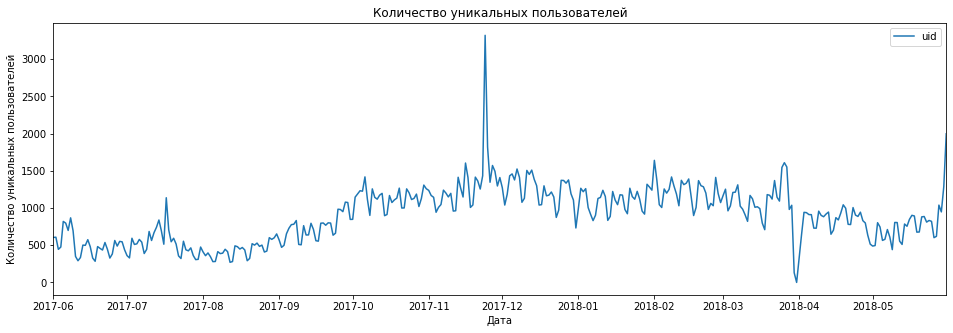

In [14]:
# Рассмотрим более детально изменение метрики WAU во времени
visits.groupby('session_date').agg({'uid': 'nunique'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Количество уникальных пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей');

По графику ежедневного использования приложения видно, что летом идёт самое низкое количество посещений Яндекс афиши.

С октября идёт более активное использование. 

Пик попадает на декабрь. 

Потом до апреля идёт примерно такое же количество посещений как и осенью. 

И в апреле идёт резкий спад.

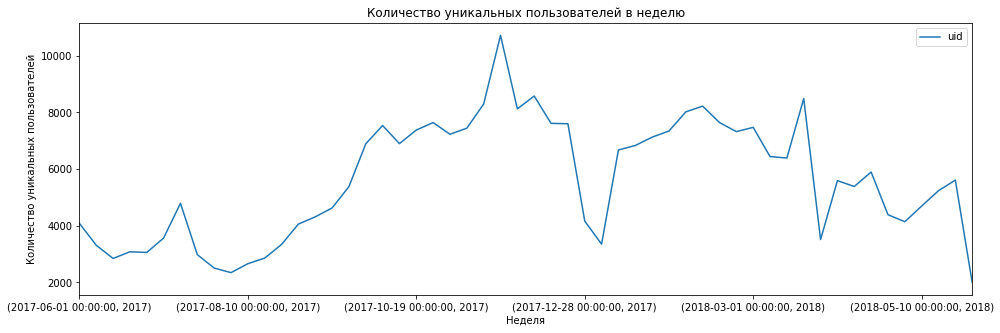

In [15]:
# Рассмотрим более детально изменение метрики WAU во времени
visits.groupby(['session_week', 'session_year']).agg({'uid': 'nunique'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Количество уникальных пользователей в неделю')
plt.xlabel('Неделя')
plt.ylabel('Количество уникальных пользователей');

По графику еженедельного использования яндекс афиши видно, что где то до 12 недели (начала апреля) идёт активное использования приложения, около 7 тысяч посещений в неделю.

С 15 недели вплость до 35 недели (до сентября) идёт низкое посещение приложения, менее 4000 посещений в месяц.

После 40 недели идёт повышенное использования приложения - свыше 8000 посещений в месяц, самый пик приходит на 48 неделю (начало декабря) - свыше 10000 посещений.

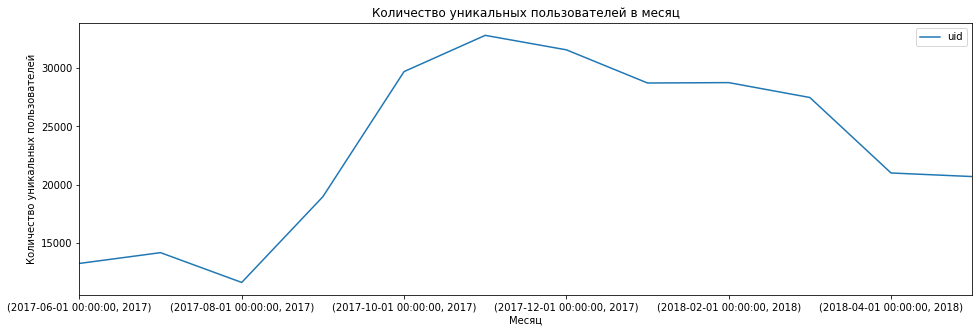

In [16]:
# Рассмотрим более детально изменение метрики MAU во времени
visits.groupby(['session_month', 'session_year']).agg({'uid': 'nunique'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Количество уникальных пользователей в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей');

По ежемесячному графику видно, что до 4 месяца (апреля) идёт активное использования, около 30-25 тысяч посещений в месяц.

С 5 месяца (мая) идёт понижение, вполоть до 8 месяца (августа), с посещениями менее 15 тысяч в месяц.

После 8 месяца идёт прирост, и в 10 месяце (октябре) он уже составляет более 30 тысяч посещений в месяц. И такой уровень остаётся до 12 месяца (декабря).

#### Среднее использование в день приложения и время сессии

Посмотрим, сколько раз за день пользователи в среднем заходят на сайт.

In [17]:
# Высчитаем среднее посещение яндекс афиши в день всеми пользователями
sessions_per_day  = visits.groupby('session_date').agg({'uid': 'count'}).mean()
print('Среднее количество посещений в день:', int(sessions_per_day))

Среднее количество посещений в день: 987


Среднее количество заходов на сайт в день отличается от среднего количества пользователей в день.
Это говорит о том, что некоторые пользователи несколько раз в день используют приложение.

In [18]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
# Рассчитаем как часто в день один и тот же пользователь пользуется приложением
sessions_per_user = sessions_per_day / dau_total
print(sessions_per_user)

uid    1.087414
dtype: float64


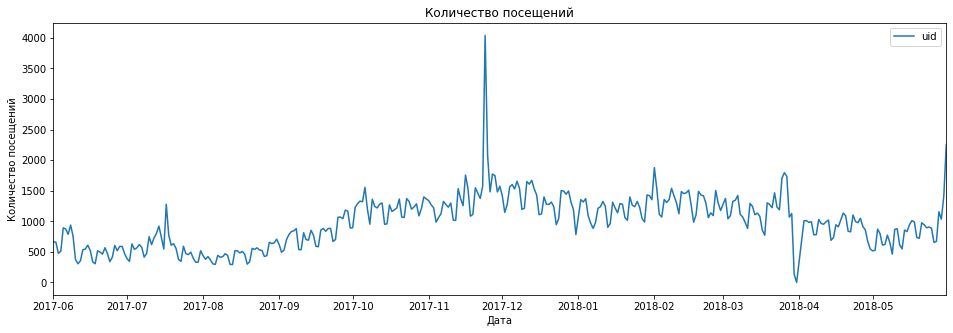

In [19]:
# Рассмотрим более подробно по количеству сессий в день
visits.groupby('session_date').agg({'uid': 'count'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Количество посещений')
plt.xlabel('Дата')
plt.ylabel('Количество посещений');

По факту данное распределение не отличается от распределение DAU, разница лишь в количестве. Количества сессий по факту больше, чем количество новых пользователей в день ~на 8%.

Посмотрим, сколько времени пользователи проводят на сайте.

In [20]:
# Найдём ASL — посчитаем длину всех сессий и вычислим среднее:

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Среднее время одной сессии:', visits['session_duration_sec'].mean(), 'секунды') 

Среднее время одной сессии: 643.506488592098 секунды


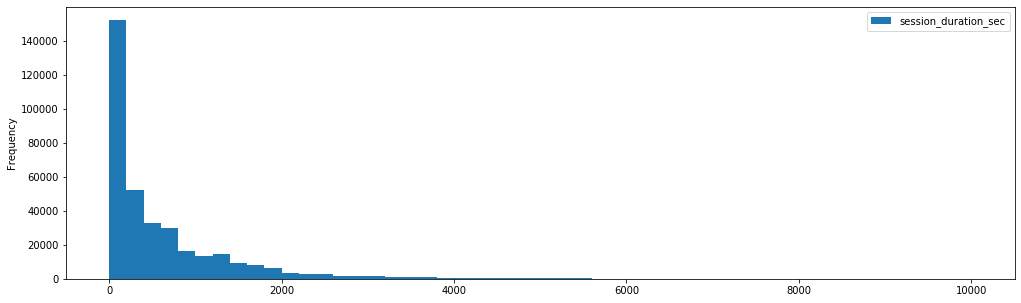

In [21]:
# Но посмотрим на распределение
visits.plot(y='session_duration_sec', kind='hist', range = (0, 10000), bins = 50, figsize = (17,5));

In [22]:
# Наше распределение не похоже на нормальное, так что высчитаем моду
print(visits['session_duration_sec'].mode())

0    60
dtype: int64


Получается продолжительность типичной пользовательской сессии за весь период составляет 60 секунд.

Это очень мало, возможно у Яндекс Афиши какие то проблемы с сайтом или мобильным приложением.

####  Retention Rate

Применяя когортный анализ, рассчитаем Retention Rate.

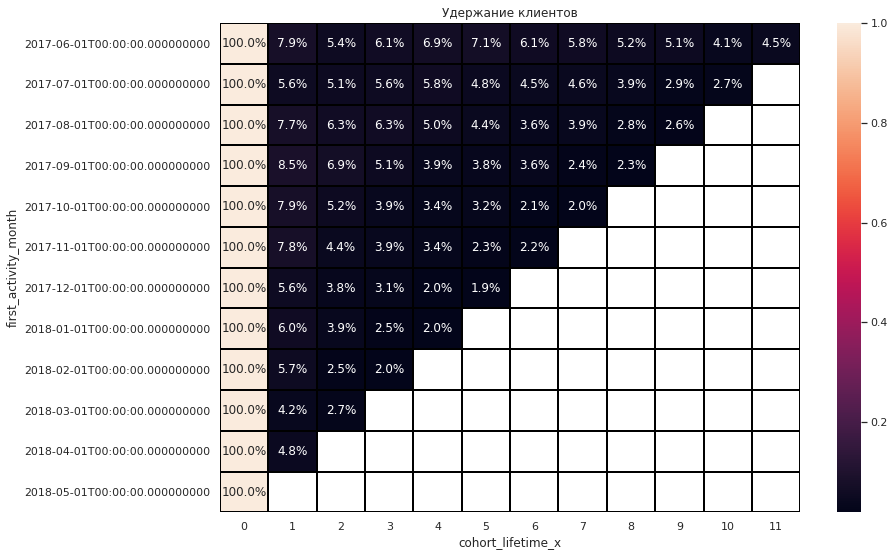

In [23]:
# Создадим таблицу, которая будет содержать информацию о дате первой активности в приложении
first_activity_date = visits.groupby(['uid'])['session_date'].min()

# Переименуем её, чтобы у нас не было в таблице двух столбцов в одинаковым названием
first_activity_date.name = 'first_activity_date'

# Объединим его с нашей основной таблицей по визитам в приложении по столбцу Id клиента
visits = visits.join(first_activity_date, on='uid')

# Добавим новый столбец с номером месяца первой активности
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

# Добавим новый столбец с номером месяца активности
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

# Создадим новый столбец cohort_lifetime с порядковым месяцем относительно месяца первой активности
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

# Создадим таблицу с когортами
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Создадим таблицу с 0ой когортой
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
# Переименуем в ней столбец по Id, чтобы не было повторяющихся столбцов
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Объединим таблицу с когортами и с 0ой когортой по стоблцу месяца первой активности
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

# Создадим столбец с Retention Rate 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

# Создадим сводную таблицу по когортам
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime_x',
    values='retention',
    aggfunc='sum',
)

# Составим цветовую карту для наглядности
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Удержание клиентов')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black');

In [24]:
# Найдём средний Retention Rate на второй месяц «жизни» когорт.
middle_Retention_Rate = cohorts[cohorts['cohort_lifetime_x'] == 1]
print('На второй месяц возвращается всего', middle_Retention_Rate['retention'].mean() * 1000, 'человек из 1000')

На второй месяц возвращается всего 65.16659710392834 человек из 1000


График выглядит не оптимистично, относительно первого использования тот же клиент возвращается всего в 6% случаев обратно на Яндекс.Афишу

#### Вывод

В средней на Яндекс.Афишу заходит достаточно новых клиентов:

Среднее количество уникальных пользователей **в день: 907**, **в неделю: 5716**, **в месяц: 23228**.

Летом идёт провал в использовании, с осени по весну активно, самый активные месяца - это ноябрь и декабрь.
Для сайта с мероприятиями это хороший показатель: летом мероприятий меньше, чем в остальное время года, и люди летом находят другие альтернативы концертам, театрам и т.д.

При этом самое распространённое время сессии составляет 60 секунд.

И показатель Retention Rate (сколько клиентов вернулось для повторного использования, относительно первого месяца) оставляет желать лучшего. В среднем на 1000 клиентов только 65 клиентов возвращается.

Скорее всего у Яндекс.Афиши какие-то проблемы с сайтом. Возможно клиентам не удобно использовать его, или возможны проблемы с мобильной версией.

### Метрики электронной коммерции

#### Сколько занимает время первой покупки

Рассчитаем сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

In [25]:
# Создадим новый столбец session_date, чтобы в объединить таблицы без ошибок

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'],format='%Y.%m.%d')
orders['session_date'] = orders['buy_ts'].dt.date
# Соединим две таблицы visits и orders по столбцу UID
orders_visits = orders.merge(visits, on=['uid', 'session_date'])

# Высчитаем сколько времени проходит между посещением до покупки в секундах
orders_visits['time_before_purchase'] = (orders_visits['buy_ts'] - orders_visits['start_ts']).dt.seconds

# И выведем среднее
print('Среднее от посещения сайта впервые до покупки:', orders_visits['time_before_purchase'].mean(), 'секунды') 

Среднее от посещения сайта впервые до покупки: 12528.747546703496 секунды


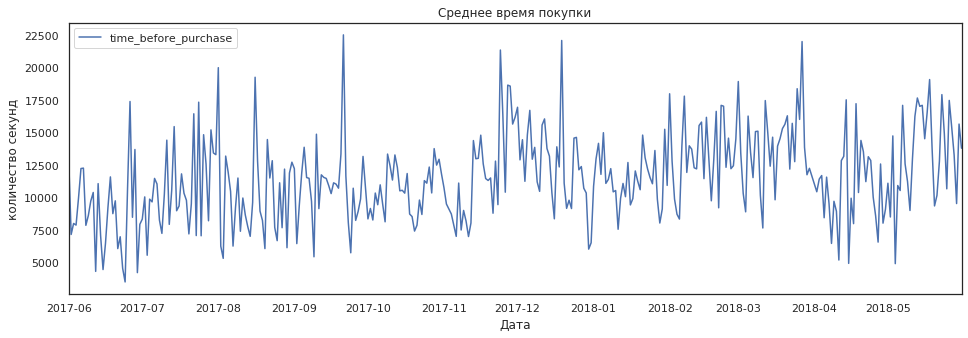

In [26]:
# Посмотрим как менялось среднее время от посещения до покупки во времени
orders_visits.groupby('session_date').agg({'time_before_purchase': 'mean'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Среднее время покупки')
plt.xlabel('Дата')
plt.ylabel('количество секунд');

Среднее время от первого посещения до первой покупки состаляет на протяжении всего года в среднем 12 500 секунд (~3,5 часа).

Есть выборочные пики, которые доходят до 22 500 секунд (~6 часов)

#### Среднее количество покупок на клиента в месяц

Применяя когортный анализ, рассчитаем среднее количество покупок на одного покупателя за месяц.

In [27]:
#определим дату и время первой сессии каждого пользователя.
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

# для удобства группировки, добавим колонки даты и месяца
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')

# Найдем время первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

# объединяем данные о первых покупках с данными о первых сессиях
buyers = pd.merge(first_visits, first_orders, on='uid')

In [28]:
#построим когортный отчет от даты первой покупки
# Найдем число покупателей в каждой когорте
cohort_sizes = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

# Добавим в информацию о покупках месяц первой покупки
cohorts = pd.merge(orders, buyers, how='inner', on='uid')\
            .groupby(['first_order_month', 'order_month'])\
            .agg({'revenue': 'count'}).reset_index()
# Считаем возраст каждой когорты
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
cohorts.columns = ['first_order_month', 'order_month', 'n_orders', 'age_month']

# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем количество заказов на каждого покупателя.
cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

# Возростной когортный отчет, показывающий накопительное число покупок на покупателя

cohorts_age = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


In [29]:
print('Среднее количество покупок на клиента', round(cohorts_age[5].mean(), 2), 'в месяц')

Среднее количество покупок на клиента 1.43 в месяц


#### Средний чек

Рассчитаем средний чек по времени совершения покупки.

In [30]:
# Выведем среднее значение суммы покупки для всей таблицы orders
print('Средняя сумма чека составляет', round(orders['revenue'].mean()), 'у.е.')

Средняя сумма чека составляет 5 у.е.


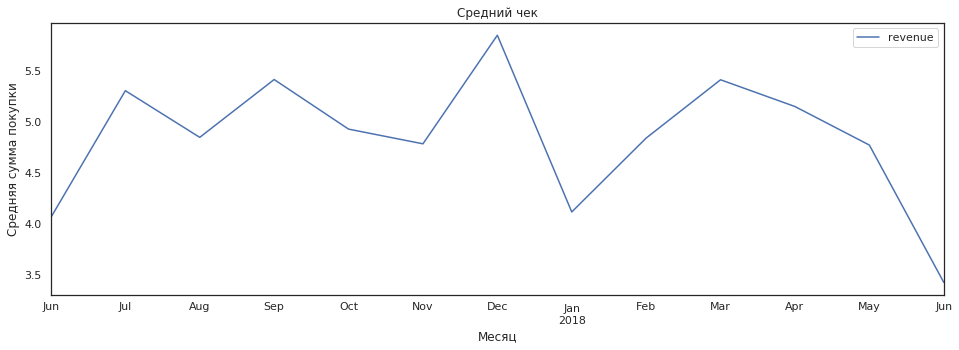

In [31]:
# Построим график, где будет видно изменение среднего чека по месяцам
orders.groupby(orders['order_month']).agg({'revenue': 'mean'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Средний чек')
plt.xlabel('Месяц')
plt.ylabel('Средняя сумма покупки');

Средняя сумма покупки на одного клиента за всё время составляет 5 у.е.

С августа по декабрь идёт увеличенный чек свыше 5 у.е., с пиками в сентябре и декабре (до 6,5 у.е.)

С января по май идёт стабильный средний чек (видимо покупки ниже 5 у.е. просто редкость из-за стоимости товара)

#### LTV 

Рассчитаем средний LTV по когортам, прожившим не менее 6 месяцев.

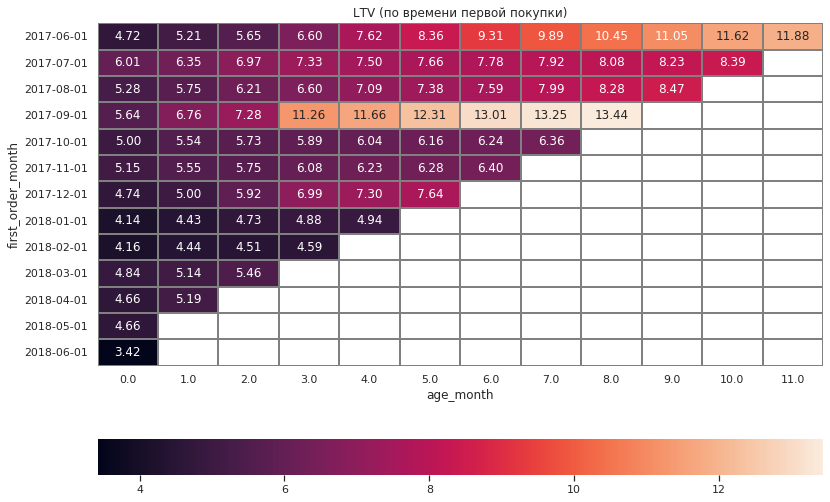

In [32]:
# Найдем число покупателей в каждой когорте
cohort_sizes = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

# Добавим в информацию о покупках месяц первой покупки
cohorts = pd.merge(orders, buyers, how='inner', on='uid')\
        .groupby(['first_order_month', 'order_month'])\
        .agg({'revenue': 'sum'}).reset_index()

# Считаем возраст каждой когорты
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']

# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем выручку на каждого покупателя.
cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']

# Возростной когортный отчет, показывающий накопительную выручку на покупателя

cohorts_age = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='rev_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')

plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_age, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='LTV (по времени первой покупки)', yticklabels = cohorts_age.index.astype('str'))
plt.show()


In [33]:
print('Среднее LTV', round(cohorts_age[5].mean(),2), 'у.е.')

Среднее LTV 7.97 у.е.


#### Вывод

Расчеты метрик электронной коммерции показали следующие результаты:

 - Среднее время от первого посещения до первой покупки состаляет на протяжении всего года составляет ~3,5 часа.
 - Среднее количество покупок на одного клиента это 1,43 покупки.
 - Средний чек на одного клиента составляет 5 у.е.
 - Средний LTV составляет 7,97 у.е. за пол года.
 
Можно сделать предположение, что приложение имет какой-то неудобный вид, что среднее время покупки составляет 3,5 часов.
Клиент скорее всего уходят с сайта и через какое-то время возвращаются завершить покупку.

В среднем клиент в месяц совершает 1,43 покупки с суммой 5 у.е. 

Средняя ценность клиента за 6 месяцев составляет 50 у.е. 

### 2.3. Маркетинговые метрики

#### Общая сумма расходов на маркетинг. Распределение трат по источникам

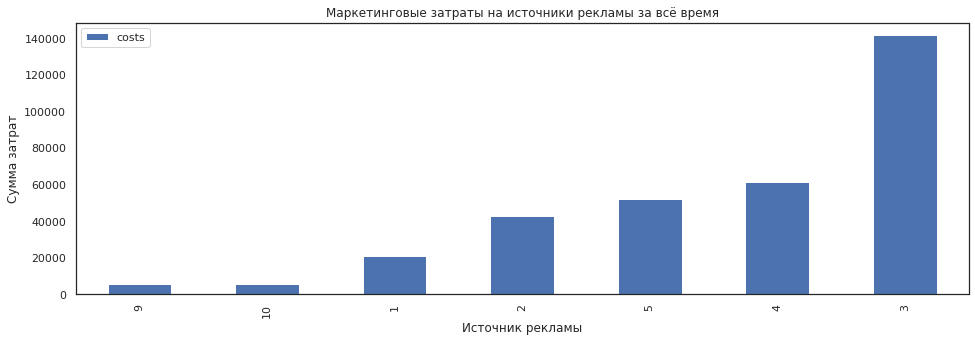

In [34]:
# Создадим новую таблицу группировкой по источникам и посчитаем общие затраты
costs_1 = costs.groupby('source_id').agg({'costs': 'sum'})

# Выведем график на экран
costs_1.sort_values('costs', ascending = True).plot(figsize=(16, 5), kind = 'bar')

# Добавим подписи к графику
plt.title('Маркетинговые затраты на источники рекламы за всё время')
plt.xlabel('Источник рекламы')
plt.ylabel('Сумма затрат');

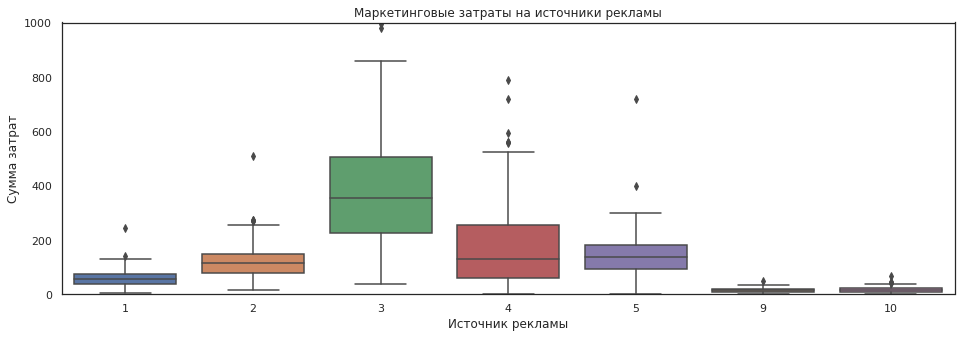

In [35]:
# Создадим график boxplot для источников рекламы
plt.figure(figsize=(16, 5)) 
sns.boxplot(data=costs, x='source_id', y='costs');
plt.ylim(0,1000)

# Добавим подписи к графику
plt.title('Маркетинговые затраты на источники рекламы')
plt.xlabel('Источник рекламы')
plt.ylabel('Сумма затрат');

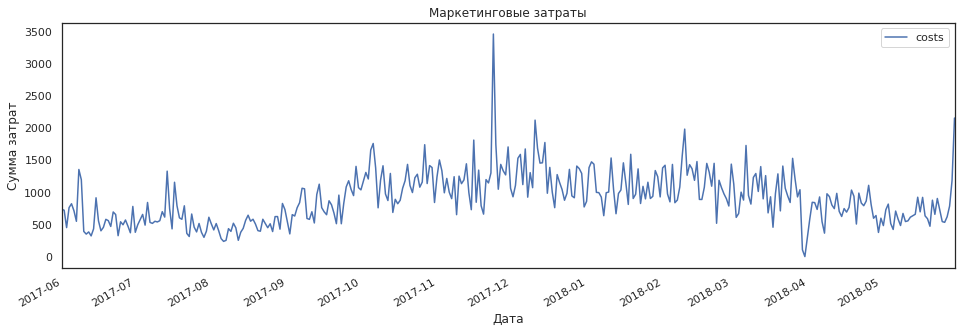

In [36]:
# Также посмотрим, как меняются затраты по времени
costs.groupby('dt').agg({'costs': 'sum'}).plot(figsize=(16, 5))

# Добавим подписи к графику
plt.title('Маркетинговые затраты')
plt.xlabel('Дата')
plt.ylabel('Сумма затрат');

In [37]:
# Выведем на экран сколько всего было потрачено на маркетинг
print('Всего на маркетинг было потрачено:', costs_1['costs'].sum(), 'у.е.')

Всего на маркетинг было потрачено: 329131.6199999999 у.е.


Всего на маркетинг было потрачено 329 131 у.е.:

На первый истоник - 20 833,27 у.е.

На второй источник - 42 806,04 у.е.

На третий истоник - 141 321,63 у.е.

На четвертый источник - 61 073,6 у.е.

На пятый источник - 51 757,1 у.е.

На девятый источник - 5517,49 у.е.

На десятый источник - 5822,49 у.е.

Пик трат на привлечение клиентов попадает на декабрь, здесь доходит до 3500 у.е. в день.

#### Средний CAC на одного покупателя в месяц.

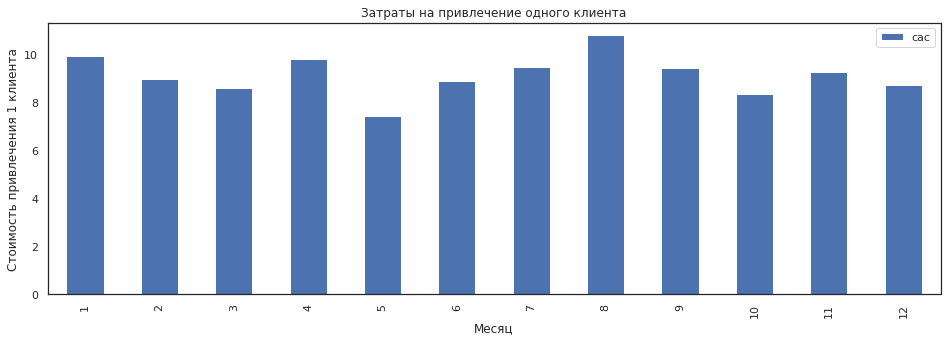

In [38]:
# Создадим таблицу группировкой, чтобы отображался только месяц заказа и сумма трат за этот месяц
costs['month']= costs['dt'].dt.month
costs_1 = costs.groupby('month').agg({'costs': 'sum'})

# Создадим новый столбец с месяцем в таблице cohort_sizes, чтобы мы смогли соединить по ней
cohort_sizes['month'] = cohort_sizes['first_order_month'].dt.month
#Удалим 6 месяц 2018 года, чтобы в будущем построить график по месяцам
cohort_sizes = cohort_sizes.loc[cohort_sizes['first_order_month'] != '2018-06-01']

# Объединим две таблицы в одну
costs_2 = pd.merge(costs_1, cohort_sizes, on = 'month')

# Создадим новый столбец со значением CAC
costs_2['cac'] = costs_2['costs'] / costs_2['n_buyers']

# Построим график по CAC
costs_2.plot(x = 'month', y = 'cac', kind='bar', figsize=(16, 5))

# Добавим подписи к графику
plt.title('Затраты на привлечение одного клиента')
plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения 1 клиента');

In [39]:
print('В среднем на привлечение одного клиента тратиться', costs_2['cac'].mean(), 'у.е.')

В среднем на привлечение одного клиента тратиться 9.14735729248254 у.е.


По графику видим, что для привлечения одного клиента по месяцам тратилось:
 - в январе - 9,93 у.е.
 - в феврале - 8,96 у.е.
 - в марте - 8,6 у.е.
 - в апреле - 9,79 у.е.
 - в мае - 7,43 у.е.
 - в июне - 8,9 у.е.
 - в июле - 9,48 у.е.
 - в августе - 10,79 у.е.
 - в сентябре - 9,44 у.е.
 - в октябре - 8,36 у.е.
 - в ноябре - 9,28 у.е.
 - в декабре - 8,74 у.е.
 
Самая высокая цена привлечения клиенты была в августе - 10,79 у.е.
Самая низкая в мае - 7,43 у.е.
 
В среднем же для привлечение одного клиента вне зависимости от рекламного канала тратиться 9,14 у.е.

#### Romi в разрезе источников

##### Рассчитаем Romi по когортам по первому рекламному источнику

In [40]:
first_visits_romi = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits_romi.columns = ['uid', 'first_visits_datetime']

first_visits_romi['first_visits_date'] = first_visits_romi['first_visits_datetime'].dt.date
first_visits_romi['first_visits_month'] = first_visits_romi['first_visits_datetime'].astype('datetime64[M]')

first_orders_romi = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders_romi.columns = ['uid', 'first_order_datetime']
buyers_romi = pd.merge(first_orders_romi, first_visits_romi, on='uid')

orders_new_romi = pd.merge(orders, buyers_romi, on='uid')
orders_new_romi['order_month'] = orders_new_romi['buy_ts'].astype('datetime64[M]')
orders_new_romi['first_order_month'] = orders_new_romi['first_order_datetime'].astype('datetime64[M]')
users_romi = visits.sort_values('start_ts').groupby('uid').first()
users_romi = users_romi[['source_id']]

#del orders_new_romi['source_id']
orders_new_romi = pd.merge(orders_new_romi, users_romi, left_on='uid', right_index=True)


cohort_sizes_t_romi = (
    orders_new_romi.groupby(['source_id', 'first_order_month'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t_romi.columns = ['source_id', 'first_order_month', 'n_buyers']


cohorts_revenue_t_romi = (
    orders_new_romi.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t_romi.columns = ['source_id', 'first_order_month', 'order_month', 'gp']


report_romi = pd.merge(cohort_sizes_t_romi, cohorts_revenue_t_romi, on=['source_id', 'first_order_month'])
report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')
report_romi['age'] = report_romi['age'].round().astype('int')
report_romi['ltv'] = report_romi['gp'] / report_romi['n_buyers']

costs['costs_month'] = costs['dt'].astype('datetime64[M]')

report_romi = pd.merge(report_romi,costs.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
report_romi = report_romi.drop(['costs_month'], axis = 1) 
report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']

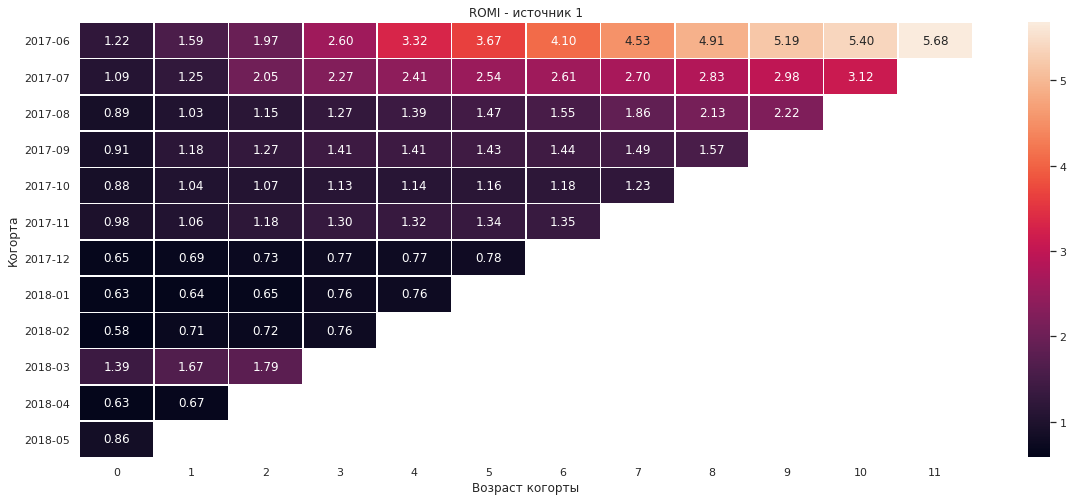

In [41]:
romi_1 = report_romi.query('source_id == 1')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_1.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 1')
sns.heatmap(romi_1, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_1.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

In [42]:
# Создадим таблицу только по первому рекламному источнику
romi_1 = report_romi.query('source_id == 1')

# Выведем новую таблицу и посчитаем среднюю накопительную romi за пол года
final_result = romi_1.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

# Выведем среднюю стоимость привлечения одного клиента по первому рекламному источнику
print('Средняя стоимость привлечения одного клиента по первому рекламному источнику:', romi_1['cac'].mean(), 'у.е.')

# посчитаем среднюю накопительную romi за пол года
m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]
print('Средний romi за 6 месяцев после первой покупки по первому рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по первому рекламному источнику: 7.1476195408246594 у.е.
Средний romi за 6 месяцев после первой покупки по первому рекламному источнику: 1.7685762519562231


То есть по привлечению с первого рекламного источника клиенты приносят за пол года в 1,76 раз больше, чем было на них затрачено.

##### Рассчитаем Romi по когортам по второму рекламному источнику

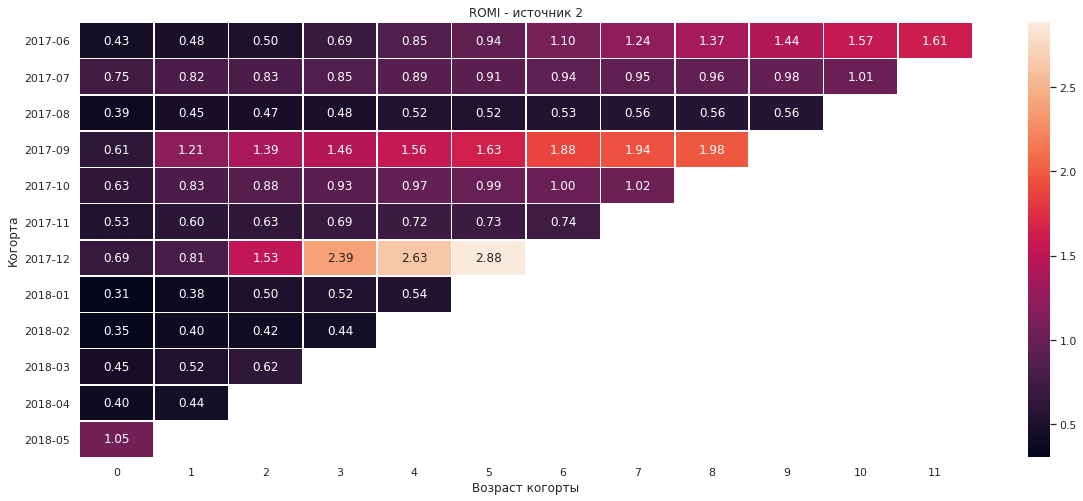

In [43]:
romi_2 = report_romi.query('source_id == 2')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_2.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 2')
sns.heatmap(romi_2, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_2.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [44]:
# Создадим таблицу только по второму рекламному источнику
romi_2 = report_romi.query('source_id == 2')

# Выведем среднюю стоимость привлечения одного клиента по второму рекламному источнику
print('Средняя стоимость привлечения одного клиента по второму рекламному источнику:', romi_2['cac'].mean(), 'у.е.')

final_result = romi_2.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по второму рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по второму рекламному источнику: 12.639599632815052 у.е.
Средний romi за 6 месяцев после первой покупки по второму рекламному источнику: 1.2294956569473146


То есть по привлечению со второго рекламного источника клиенты приносят за пол года в 1.23 раз больше, чем было на них затрачено.

##### Рассчитаем Romi по когортам по третьему рекламному источнику

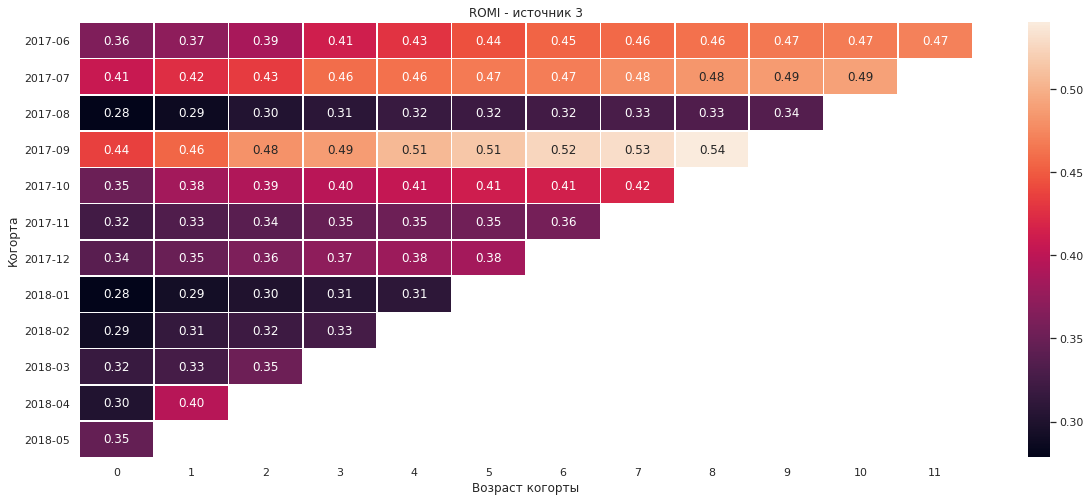

In [45]:
romi_3 = report_romi.query('source_id == 3')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_3.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 3')
sns.heatmap(romi_3, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_3.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [46]:
# Создадим таблицу только по третьему рекламному источнику
romi_3 = report_romi.query('source_id == 3')

# Выведем среднюю стоимость привлечения одного клиента по третьему рекламному источнику
print('Средняя стоимость привлечения одного клиента по третьему рекламному источнику:', romi_3['cac'].mean(), 'у.е.')

final_result = romi_3.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по третьему рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по третьему рекламному источнику: 14.056894256450041 у.е.
Средний romi за 6 месяцев после первой покупки по третьему рекламному источнику: 0.413851219275537


То есть по привлечению с третьего рекламного источника клиенты приносят за пол года всего 41% от затрат, потраченных на их привлечение.

##### Рассчитаем Romi по когортам по четвёртому рекламному источнику

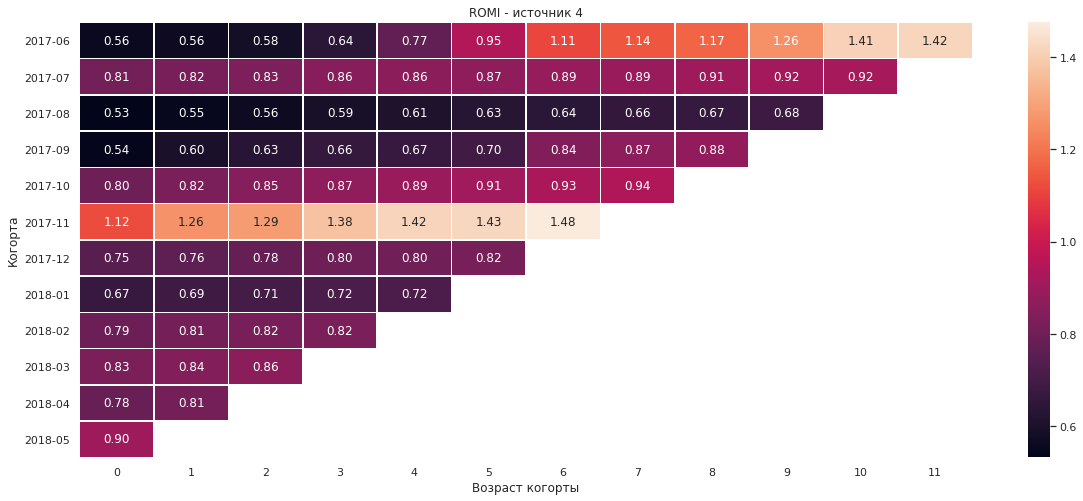

In [47]:
romi_4 = report_romi.query('source_id == 4')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_4.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 4')
sns.heatmap(romi_4, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_4.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [48]:
# Создадим таблицу только по четвёртому рекламному источнику
romi_4 = report_romi.query('source_id == 4')

# Выведем среднюю стоимость привлечения одного клиента по четвёртому рекламному источнику
print('Средняя стоимость привлечения одного клиента по четвёртому рекламному источнику:', romi_4['cac'].mean(), 'у.е.')

final_result = romi_4.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по четвёртому рекламному источнику: 6.9805283784792636 у.е.
Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику: 0.9002968563933971


То есть по привлечению с четвёртого рекламного источника клиенты приносят на 10% меньше, чем было на них затрачено.

##### Рассчитаем Romi по когортам по пятому рекламному источнику

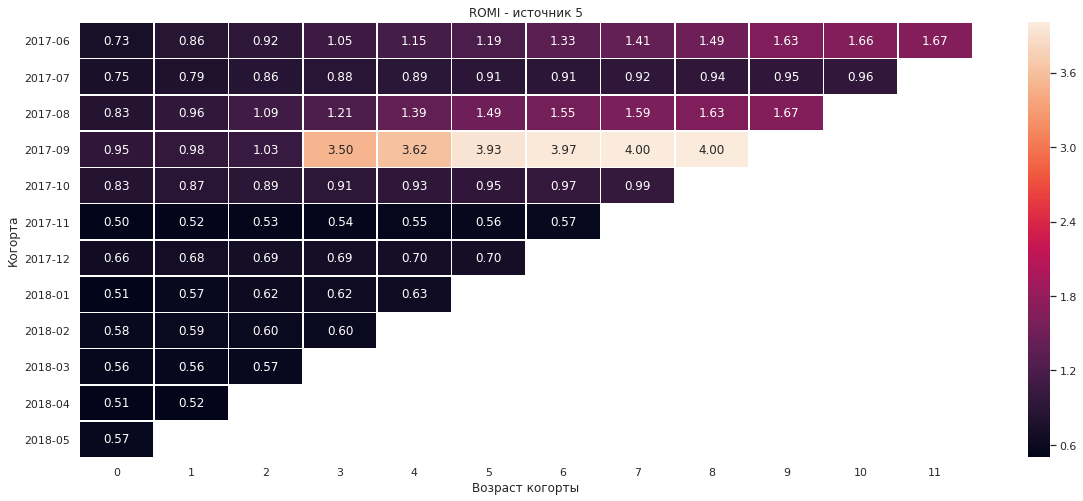

In [49]:
romi_5 = report_romi.query('source_id == 5')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_5.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 5')
sns.heatmap(romi_5, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_5.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [50]:
# Создадим таблицу только по четвёртому рекламному источнику
romi_5 = report_romi.query('source_id == 5')

# Выведем среднюю стоимость привлечения одного клиента по пятому рекламному источнику
print('Средняя стоимость привлечения одного клиента по пятому рекламному источнику:', romi_5['cac'].mean(), 'у.е.')

final_result = romi_5.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по пятому рекламному источнику: 7.171887249253396 у.е.
Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику: 1.3877311463832833


То есть по привлечению с пятого рекламного источника клиенты приносят за пол года в 1,39 раз больше, чем было на них затрачено.

##### Рассчитаем Romi по когортам по девятому рекламному источнику

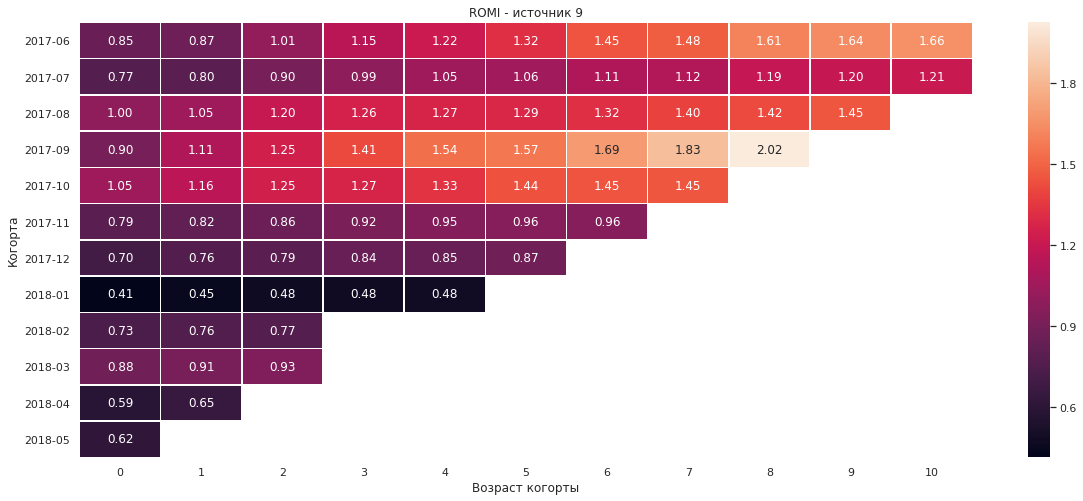

In [51]:
romi_9 = report_romi.query('source_id == 9')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_9.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 9')
sns.heatmap(romi_9, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_9.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [52]:
# Создадим таблицу только по четвёртому рекламному источнику
romi_9 = report_romi.query('source_id == 9')

# Выведем среднюю стоимость привлечения одного клиента по девятому рекламному источнику
print('Средняя стоимость привлечения одного клиента по девятому рекламному источнику:', romi_9['cac'].mean(), 'у.е.')

final_result = romi_9.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по девятому рекламному источнику: 5.059116845399583 у.е.
Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику: 1.2162181621522414


То есть по привлечению с девятого рекламного источника клиенты приносят за пол года на 21% больше, чем было на них затрачено.

##### Рассчитаем Romi по когортам по десятому рекламному источнику

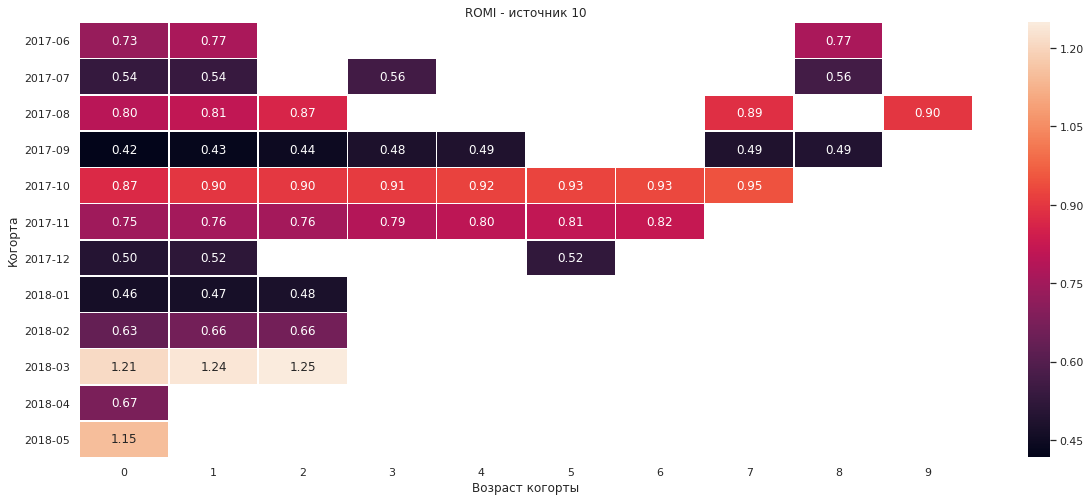

In [53]:
romi_10 = report_romi.query('source_id == 10')\
        .pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')\
        .cumsum(axis=1)
romi_10.round(2).fillna('')

plt.figure(figsize=(20, 8))
plt.title('ROMI - источник 10')
sns.heatmap(romi_10, annot=True, fmt=".2f", linewidths=.5,
           yticklabels=romi_10.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')

plt.show()

In [54]:
# Создадим таблицу только по четвёртому рекламному источнику
romi_10 = report_romi.query('source_id == 10')

# Выведем среднюю стоимость привлечения одного клиента по десятому рекламному источнику
print('Средняя стоимость привлечения одного клиента по десятому рекламному источнику:', romi_10['cac'].mean(), 'у.е.')

final_result = romi_10.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean')

m6_cum_romi = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику:', m6_cum_romi)

Средняя стоимость привлечения одного клиента по десятому рекламному источнику: 5.039288942212309 у.е.
Средний romi за 6 месяцев после первой покупки по четвёртому рекламному источнику: 0.7540707529857004


То есть по привлечению с десятого рекламного источника клиенты приносят за пол года на 25% меньше, чем было на них затрачено.

In [55]:
# Выведем средний LTV для каждого рекламного источника
ltv_per_source = report_romi.groupby(['source_id', 'first_order_month']).agg({'ltv': 'sum'}).reset_index()

ltv_per_source.groupby('source_id').agg({'ltv': 'mean'}).reset_index()

,source_id,ltv
0,1,11.929500
1,2,13.086231
2,3,5.411270
3,4,6.004837
4,5,7.849365
5,9,5.531592
6,10,3.481566


#### Вывод

Маркетинговые затраты **на первый истоник: всего - 20 833,27 у.е., на привлечение одного клиента 7,14 у.е.**.
Также **Romi** за пол года по данному источнику **равен 1,76**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит в 1,76 раза больше, чем было потрачено на его привлечение.

Маркетинговые затраты **на второй источник: всего - 42 806,04 у.е, на привлечение одного клиента 12,6 у.е.**
Также **Romi** за пол года по данному источнику **равен 1,22**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит в 1,4 раза больше, чем было потрачено на его привлечение.

Маркетинговые затраты **на третий истоник: всего - 141 321,63 у.е., на привлечение одного клиента 14,05 у.е.**
Также **Romi** за пол года по данному источнику **равен 0,41**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит всего 41% от затрат, потраченных на его привлечение.

Маркетинговые затраты **на четвертый источник: всего - 61 073,6 у.е., на привлечение одного клиента 6,98 у.е.**
Также **Romi** за пол года по данному источнику **равен 0,90**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит на 10% меньше, чем было потрачено на его привлечение.

Маркетинговые затраты **на пятый источник: всего - 51 757,1 у.е., на привлечение одного клиента 7,17 у.е.**
Также **Romi** за пол года по данному источнику **равен 1,38**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит на 38%, чем было потрачено на его привлечение.

Маркетинговые затраты **на девятый источник: всего - 5 517,49 у.е., на привлечение одного клиента 5,05 у.е.**
Также **Romi** за пол года по данному источнику **равен 1,21**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит на 21% больше, чем было потрачено на его привлечение.

Маркетинговые затраты **на десятый источник: всего - 5 822,49 у.е., на привлечение одного клиента 5,03 у.е.**
Также **Romi** за пол года по данному источнику **равен 0,75**, то есть один клиент, пришедший с этого источника рекламы за пол года приносит на 25% меньше, чем было потрачено на его привлечение.

**Всего на маркетинг было потрачено 329 131 у.е.**, **в среднем на привлечение одного клиента** вне зависимости от источника тратится **9,14 у.е.**

## Вывод

В средней на Яндекс.Афишу заходит достаточно новых клиентов:

Среднее количество уникальных пользователей в день: 907, в неделю: 5716, в месяц: 23228.

Летом идёт провал в использовании, с осени по весну активно, самый активные месяца - это ноябрь и декабрь. Для сайта с мероприятиями это хороший показатель: летом мероприятий меньше, чем в остальное время года, и люди летом находят другие альтернативы концертам, театрам и т.д.

При этом самое распространённое время сессии составляет 60 секунд.

И показатель Retention Rate (сколько клиентов вернулось для повторного использования, относительно первого месяца) оставляет желать лучшего. В среднем на 1000 клиентов только 65 клиентов возвращается.

Расчеты метрик электронной коммерции показали следующие результаты:

 - Среднее время от первого посещения до первой покупки состаляет на протяжении всего года составляет ~3,5 часа.
 - Среднее количество покупок на одного клиента это 1,43 покупки.
 - Средний чек на одного клиента составляет 5 у.е.
 - Средний LTV составляет 7,97 у.е. за пол года.
  
Можно сделать предположение, что приложение имет какой-то неудобный вид, что среднее время покупки составляет 3,5 часов, а самое распространённое время сессии всего 60 секунд. Клиент скорее всего уходят с сайта и через какое-то время возвращаются завершить покупку. И потом редко возвращается для повторных покупок

Средняя ценность клиента составляет 7,97 у.е. на человека за пол года .

Всего на маркетинг было потрачено 329 131 у.е., в среднем на привлечение одного клиента вне зависимости от источника тратится 9,14 у.е.

По первому рекламному источнику тратится 7,14 у.е. на привлечение одного клиента, при этом клиент тратит в среднем 11,93 у.е., что в 1,76 раз больше, чем было потрачено на его привлечение. Было потрачено всего 20833 у.е.

По второму рекламному источнику на привлечение одного клиент тратится 12,6 у.е., при этом клиент тратит в среднем 13,08, что в 1,22 раз больше, чем было потрачено на его привлечение. Было потрачено всего 42806 у.е.

По третьему рекламному источнику на привлечение одного клиент тратится 14,05 у.е., при этом клиент тратит в среднем 5,41 у.е., это всего 41% от затрат на его привлечение. Было потрачено всего 141321 у.е.

По четвертому рекламному источнику на привлечение одного клиент тратится 6,98 у.е., при этом клиент тратит а среднем 6 у.е., что 10% меньше, чем было потрачено на его привлечение. Было потрачено всего 61073 у.е.

По пятому рекламному источнику на привлечение одного клиент тратится 7,17 у.е., при этом клиент тратит в среднем 7,84 у.е., что в 1,38 раз больше, чем было потрачено на его привлечение. Было потрачено всего 51757 у.е.

По девятому рекламному источнику на привлечение одного клиент тратится 5,05 у.е., при этом клиент тратит в среднем 5,53 у.е., что на 21% больше, чем было потрачено на его привлечение. Было потрачено всего 5517 у.е.

По десятому рекламному источнику на привлечение одного клиент тратится 5,03 у.е., при этом клиент тратит в стреднем 3,48 у.е., что на 25% меньше, чем было потрачено на его привлечение. Было потрачено всего 5822 у.е.

Я бы посоветовала попробовать уменьшить затраты на отрицательные рекламные источник рекламные источники, а именно 3, 4 и 10 источники. Именно с этих источников клиенты приносят меньше у.е., чем было потрачено на их привлечение.

И попробовать увеличить рекламные акция по первому и пятому. Так как у них самые высокий возврат, в 1,76 раза выше и в 1,38 раз выше, чем было затрачено на привлечение.

Также я бы посоветовала рассмотреть проблему сайта в целом. Видимо у него есть какая-то техническая ошибка, или он очень неудобен в пользовании, т.к. клиенты фактически не возвращаются для повторных покупок (65 человек из 1000 возвращаются).